## Replicación experimento artificial en 2D de Paper : Physics-Informed Neural Networks for Cardiac Activation Mapping

Francisco Sahli Costabal, Yibo Yang, Paris Perdikaris, Daniel E. Hurtado and Ellen Kuhl


## Junio 2025 - FCFM. Universidad de Chile - Curso EDP. Numerico

* Autor: Francisco Sahli C.

* Revisión y modificación del codigo : Allen Arroyo G. - allen.joseph.arroyo@gmail.com

* Github : https://github.com/fsahli/EikonalNet.git


Este documento necesita utilizar por lo menos :

Eikonal2DnetCV2 de models_tf.py del github  

https://github.com/fsahli/EikonalNet.git

Igualmente esta copiada la clase abajo en un bloque de codigo, pues se tuvo que modificar.

# Librerías

In [5]:
import tensorflow as tf

device_info = tf.config.list_physical_devices('GPU')
print("Dispositivos GPU disponibles:", device_info)
!nvidia-smi

Dispositivos GPU disponibles: []
/bin/bash: line 1: nvidia-smi: command not found


In [6]:
!git clone https://github.com/fsahli/EikonalNet.git
import sys
sys.path.append('/content/EikonalNet')

fatal: destination path 'EikonalNet' already exists and is not an empty directory.


In [7]:
!pip install pyDOE

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pyDOE import lhs
# Asegúrate de tener esta clase en el entorno
#from Eikonal2DnetCV2  import Eikonal2DnetCV2

# Mallado y solución exacta, datos de entrenamiento

In [9]:
N_grid = 50
x = y = np.linspace(0,1,N_grid)[:,None]

X_m, Y_m = np.meshgrid(x, y)
X = X_m.flatten()[:,None]
Y = Y_m.flatten()[:,None]

X_pde = X
Y_pde = Y

# Datos exactos
def exact(x, y):
    return np.minimum(np.sqrt(x**2 + y**2), 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2))

def CVexact(x, y):
    r1 = np.sqrt(x**2 + y**2)
    r2 = np.sqrt((x - 1)**2 + (y - 1)**2)
    return np.where(r1 < 0.7 * r2, 1.0, 1.0 / 0.7)

T = exact(X, Y)
CV = CVexact(X, Y)

# Datos de entrenamiento
N_train = 50
X_train_all = lhs(2, N_train)
X_train = X_train_all[:, :1]
Y_train = X_train_all[:, 1:]
T_train = exact(X_train, Y_train)

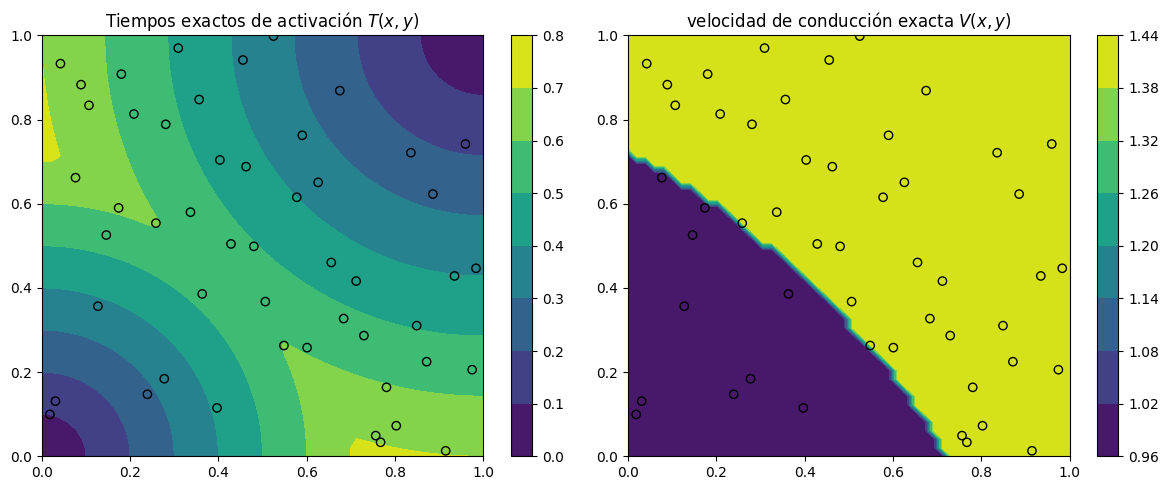

In [10]:
fig = plt.figure()
fig.set_size_inches((12,5))
plt.subplot(121)
plt.contourf(X_m, Y_m, T.reshape(X_m.shape))
plt.colorbar()
plt.scatter(X_train, Y_train, facecolors = 'none', edgecolor = 'k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Tiempos exactos de activación $T(x,y)$')

plt.subplot(122)
plt.contourf(X_m, Y_m, CV.reshape(X_m.shape))
plt.colorbar()
plt.scatter(X_train, Y_train, facecolors = 'none', edgecolor = 'k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('velocidad de conducción exacta $V(x,y)$')

plt.tight_layout()

# Clase Eikonal2DnetCV2

In [11]:
import tensorflow as tf
import numpy as np
import time
from pyDOE import lhs

class Eikonal2DnetCV2:
    def __init__(self, x, y, x_e, y_e, T_e, layers, CVlayers, C=1.0, alpha=1e-5, alphaL2=1e-6):
        self.lb = tf.convert_to_tensor(np.min(np.concatenate([x, y], axis=1), axis=0), dtype=tf.float32)
        self.ub = tf.convert_to_tensor(np.max(np.concatenate([x, y], axis=1), axis=0), dtype=tf.float32)

        self.x = tf.convert_to_tensor(x, dtype=tf.float32)
        self.y = tf.convert_to_tensor(y, dtype=tf.float32)
        self.x_e = tf.convert_to_tensor(x_e, dtype=tf.float32)
        self.y_e = tf.convert_to_tensor(y_e, dtype=tf.float32)
        self.T_e = tf.convert_to_tensor(T_e, dtype=tf.float32)

        self.C = tf.constant(C, dtype=tf.float32)
        self.alpha = alpha
        self.alphaL2 = alphaL2

        self.weights, self.biases = self.initialize_NN(layers)
        self.CVweights, self.CVbiases = self.initialize_NN(CVlayers)

    def initialize_NN(self, layers):
        def xavier_init(size):
            in_dim, out_dim = size
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], stddev=xavier_stddev), trainable=True)

        weights, biases = [], []
        for l in range(len(layers) - 1):
            weights.append(xavier_init([layers[l], layers[l + 1]]))
            biases.append(tf.Variable(tf.zeros([1, layers[l + 1]]), trainable=True))
        return weights, biases

    def neural_net(self, X, weights, biases):
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(len(weights) - 1):
            H = tf.tanh(tf.add(tf.matmul(H, weights[l]), biases[l]))
        return tf.add(tf.matmul(H, weights[-1]), biases[-1])

    def net_eikonal(self, x, y):
        XY = tf.concat([x, y], axis=1)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(XY)
            T = self.neural_net(XY, self.weights, self.biases)
            CV_raw = self.neural_net(XY, self.CVweights, self.CVbiases)
            CV = self.C * tf.sigmoid(CV_raw)

        T_x = tape.gradient(T, XY)[:, 0:1]
        T_y = tape.gradient(T, XY)[:, 1:2]
        CV_x = tape.gradient(CV, XY)[:, 0:1]
        CV_y = tape.gradient(CV, XY)[:, 1:2]
        del tape

        f_T = tf.sqrt(tf.square(T_x) + tf.square(T_y)) - 1.0 / CV
        f_CV = tf.sqrt(tf.square(CV_x) + tf.square(CV_y))
        return T, CV, f_T, f_CV

    def loss_fn(self):

        T_pred, CV_pred, f_T_pred, f_CV_pred = self.net_eikonal(self.x, self.y)
        T_e_pred, CV_e_pred, f_T_e_pred, f_CV_e_pred = self.net_eikonal(self.x_e, self.y_e)
        mse_data = tf.reduce_mean(tf.square(self.T_e - T_e_pred))
        mse_phys = tf.reduce_mean(tf.square(f_T_pred)) + tf.reduce_mean(tf.square(f_T_e_pred))
        tv_CV = tf.reduce_mean(tf.square(f_CV_pred)) + tf.reduce_mean(tf.square(f_CV_e_pred))
        l2_reg = tf.add_n([tf.nn.l2_loss(w) for w in self.weights])
        return mse_data + mse_phys + self.alpha * tv_CV + self.alphaL2 * l2_reg

    def train_step(self, optimizer):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
        grads = tape.gradient(loss, self.weights + self.biases + self.CVweights + self.CVbiases)
        optimizer.apply_gradients(zip(grads, self.weights + self.biases + self.CVweights + self.CVbiases))
        return loss

    def predict(self, x_star, y_star):
        XY_star = tf.concat([x_star, y_star], axis=1)
        T_pred = self.neural_net(XY_star, self.weights, self.biases)
        CV_raw = self.neural_net(XY_star, self.CVweights, self.CVbiases)
        CV_pred = self.C * tf.sigmoid(CV_raw)
        return T_pred, CV_pred


# Creación del modelo para una grilla espaciada en 2D

In [13]:
# Crear la grilla en 2D

N_grid = 50
x = y = np.linspace(0,1,N_grid)[:,None]

X_m, Y_m = np.meshgrid(x, y)
X = X_m.flatten()[:,None]
Y = Y_m.flatten()[:,None]

# Datos de colocation
x_pde = X           # shape (N_grid^2, 1)
y_pde = Y

# Datos de entrenamiento
x_data = X_train    # shape (N_train, 1)
y_data = Y_train
T_data = T_train

x_pde = tf.convert_to_tensor(x_pde, dtype=tf.float32)
y_pde = tf.convert_to_tensor(y_pde, dtype=tf.float32)
x_data = tf.convert_to_tensor(x_data, dtype=tf.float32)
y_data = tf.convert_to_tensor(y_data, dtype=tf.float32)
T_data = tf.convert_to_tensor(T_data, dtype=tf.float32)

# Creación del Modelo
layers = [2, 50, 50, 50, 50, 50, 1]
CVlayers = [2, 10, 10, 10, 10, 1]
CVmax = 1.5

lb = np.array([0.0, 0.0], dtype=np.float32)
ub = np.array([1.0, 1.0], dtype=np.float32)

In [14]:
model = Eikonal2DnetCV2(x_pde, y_pde, x_data, y_data, T_data, layers, CVlayers) # utiliza la clase de arriba
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [29]:
n_iter = 5_000
losses = []

for i in range(n_iter):
    with tf.GradientTape() as tape:
        loss = model.loss_fn()

    variables = model.weights + model.biases + model.CVweights + model.CVbiases
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))

    losses.append(loss.numpy())

    if i % 100 == 0:
        print(f"Iter {i}, Loss: {loss.numpy():.5e}")

Iter 0, Loss: 8.46515e-03
Iter 100, Loss: 8.84044e-03
Iter 200, Loss: 8.28759e-03
Iter 300, Loss: 8.13711e-03
Iter 400, Loss: 8.23269e-03
Iter 500, Loss: 8.68628e-03
Iter 600, Loss: 9.20421e-03
Iter 700, Loss: 8.05861e-03
Iter 800, Loss: 8.28317e-03
Iter 900, Loss: 8.06015e-03
Iter 1000, Loss: 7.72410e-03
Iter 1100, Loss: 9.20385e-03
Iter 1200, Loss: 7.49964e-03
Iter 1300, Loss: 7.41952e-03
Iter 1400, Loss: 7.61381e-03
Iter 1500, Loss: 8.54871e-03
Iter 1600, Loss: 7.17606e-03
Iter 1700, Loss: 7.07360e-03
Iter 1800, Loss: 8.05675e-03
Iter 1900, Loss: 7.28955e-03
Iter 2000, Loss: 7.00912e-03
Iter 2100, Loss: 6.67963e-03
Iter 2200, Loss: 7.40748e-03
Iter 2300, Loss: 6.72097e-03
Iter 2400, Loss: 6.59639e-03
Iter 2500, Loss: 6.42986e-03
Iter 2600, Loss: 6.31032e-03
Iter 2700, Loss: 7.91307e-03
Iter 2800, Loss: 6.26797e-03
Iter 2900, Loss: 6.48961e-03
Iter 3000, Loss: 6.31119e-03
Iter 3100, Loss: 6.10835e-03
Iter 3200, Loss: 6.71511e-03
Iter 3300, Loss: 6.10549e-03
Iter 3400, Loss: 5.90357e-

# Montar Drive para cargar parametros anteriores

In [26]:
# Monta tu colab para poder guardar cosas o extraerlas de tu drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Crear carpeta donde guardar modelos
#
import os
save_dir = "/content/drive/MyDrive/EikonalModels/"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
model.CVbiases

[<tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 0.35935172,  0.06119196, -0.17852174,  0.05844044, -0.31722224]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 0.141211  , -0.05689921,  0.13145745,  0.16106744, -0.04964802]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 0.08853304,  0.10249796,  0.09829573, -0.08091592,  0.04765277]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 5) dtype=float32, numpy=
 array([[ 0.07706347,  0.12006933,  0.07236893, -0.08001741,  0.07042278]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.07781778]], dtype=float32)>]

In [27]:
import os
import pickle

def save_model_params(model, file_path):
    """
    Guarda los pesos y sesgos del modelo en un archivo .pkl.
    """
    params = {
        "weights": [w.numpy() for w in model.weights],
        "biases": [b.numpy() for b in model.biases],
        "CVweights": [w.numpy() for w in model.CVweights],
        "CVbiases": [b.numpy() for b in model.CVbiases]
    }
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "wb") as f:
        pickle.dump(params, f)
    print(f"Modelo guardado en: {file_path}")

def load_model_params(model, file_path):
    """
    Carga los pesos y sesgos guardados desde un archivo .pkl al modelo actual.
    """
    with open(file_path, "rb") as f:
        params = pickle.load(f)

    for var, val in zip(model.weights, params["weights"]): var.assign(val)
    for var, val in zip(model.biases, params["biases"]): var.assign(val)
    for var, val in zip(model.CVweights, params["CVweights"]): var.assign(val)
    for var, val in zip(model.CVbiases, params["CVbiases"]): var.assign(val)

    print(f"Pesos cargados desde: {file_path}")

In [ ]:
!find /content/drive -name "modelo_v5000_cuadrado.pkl"

/content/drive/MyDrive/ 2025 1er Semestre/EDPn/Proyecto 2025 EDPN-Delta-PINNs/PINNs para 2do Paper Sahli Eikonal /EikonalModels/modelo_v30000.pkl


In [30]:
# Guardar modelo
save_model_params(model, "/content/drive/MyDrive/EikonalModels/modelo_v10k_v2_cuadrado.pkl")

Modelo guardado en: /content/drive/MyDrive/EikonalModels/modelo_v10k_v2_cuadrado.pkl


In [ ]:
# Luego (en otra sesión o notebook):
# /content/drive/MyDrive/EikonalModels
# /content/drive/MyDrive/ 2025 1er Semestre/EDPn/Proyecto 2025 EDPN-Delta-PINNs/PINNs para 2do Paper Sahli Eikonal /EikonalModels/modelo_v50000.pkl"
# /content/drive/MyDrive/ 2025 1er Semestre/Proyecto 2025 EDPN-Delta-PINNs/PINNs para 2do Paper Sahli Eikonal /EikonalModels/modelo_v20000.pkl

#path = "/content/drive/MyDrive/EikonalModels/modelo_v15_000_cuadrado.pkl"#
path = "/content/drive/MyDrive/ 2025 1er Semestre/Proyecto 2025 EDPN-Delta-PINNs/PINNs para 2do Paper Sahli Eikonal /EikonalModels/modelo_v1.pkl"
load_model_params(model, path)

Pesos cargados desde: /content/drive/MyDrive/ 2025 1er Semestre/Proyecto 2025 EDPN-Delta-PINNs/PINNs para 2do Paper Sahli Eikonal /EikonalModels/modelo_v1.pkl


# Optimizar con L-BFGS (Opcional)

Lo de tensorflow-probability sirve para optimzar con L-BFGS, pero con epocas altas se demora mucho

In [ ]:
!pip install -q tensorflow-probability

In [ ]:
import tensorflow_probability as tfp

In [ ]:
# Combinar todas las variables del modelo en una lista
def get_model_variables(model):
    return model.weights + model.biases + model.CVweights + model.CVbiases

# Convertir a un solo vector plano
def flatten_weights(model):
    return tf.concat([tf.reshape(v, [-1]) for v in get_model_variables(model)], axis=0)

# Asignar un vector plano de vuelta a las variables del modelo
def assign_flat_weights(model, flat_weights):
    variables = get_model_variables(model)
    idx = 0
    for v in variables:
        shape = v.shape
        size = tf.reduce_prod(shape)
        new_vals = tf.reshape(flat_weights[idx:idx+size], shape)
        v.assign(tf.cast(new_vals, tf.float32))
        idx += size

def loss_and_grad(w):
    with tf.GradientTape() as tape:
        assign_flat_weights(model, w)
        loss = model.loss_fn()
    variables = get_model_variables(model)
    grads = tape.gradient(loss, variables)
    grads_flat = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)
    return loss, grads_flat


In [ ]:
# Inicializar vector de pesos
w0 = flatten_weights(model)

# Ejecutar L-BFGS
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=loss_and_grad,
    initial_position=w0,
    max_iterations=5000
)

# Asignar los pesos óptimos al modelo
assign_flat_weights(model, results.position)
print("Final loss:", results.objective_value.numpy())


KeyboardInterrupt: 

# Graficos de resultados

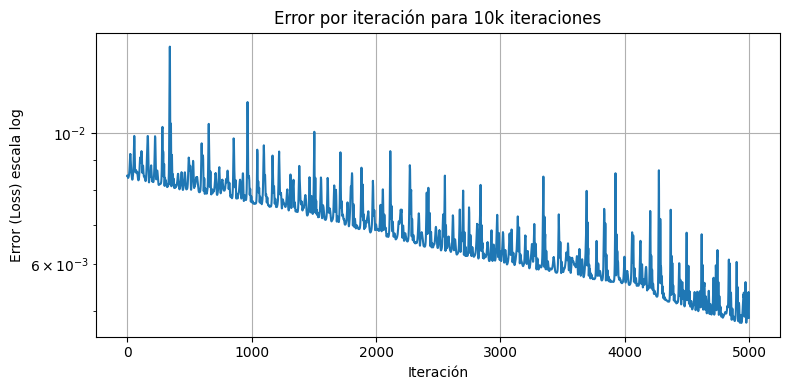

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Iteración')
plt.ylabel('Error (Loss) escala log')
plt.title('Error por iteración para 10k iteraciones')
plt.yscale('log')  # Opcional: escala logarítmica para ver mejor la convergencia
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Convertir los datos a tensores float32
N_grid = 50
x = y = np.linspace(0,1,N_grid)[:,None]

X_m, Y_m = np.meshgrid(x, y)
X = X_m.flatten()[:,None]
Y = Y_m.flatten()[:,None]

X_eval = tf.convert_to_tensor(X, dtype=tf.float32)
Y_eval = tf.convert_to_tensor(Y, dtype=tf.float32)

# Obtener predicciones
T_star, CV_star = model.predict(X_eval, Y_eval)

# Convertir a NumPy y reordenar para graficar
T_star = T_star.numpy().reshape(X_m.shape)
CV_star = CV_star.numpy().reshape(X_m.shape)

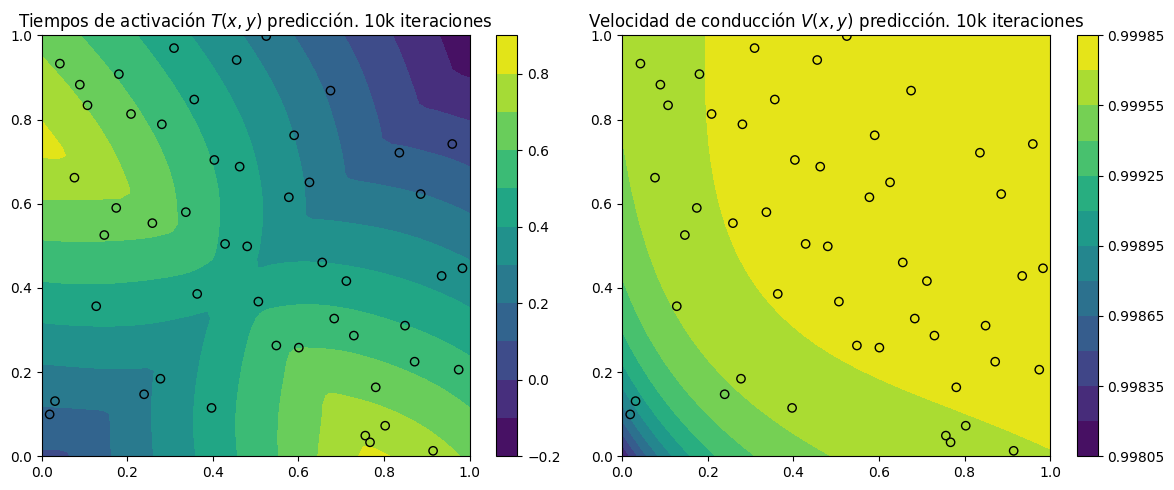

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

# Activación
plt.subplot(121)
# Hace un gráfico de contornos rellenos (filled contour plot)
# # Indica que quieres dibujar 10 niveles de contorno (es decir, 10 colores distintos que representan intervalos de valores).
plt.contourf(X_m, Y_m, T_star, 10, cmap='viridis')
plt.colorbar()
plt.scatter(X_train, Y_train, facecolors='none', edgecolor='k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Tiempos de activación $T(x,y)$ predicción. 10k iteraciones')

# Velocidad de conducción
plt.subplot(122)
plt.contourf(X_m, Y_m, CV_star, 10, cmap='viridis')
plt.colorbar()
plt.scatter(X_train, Y_train, facecolors='none', edgecolor='k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Velocidad de conducción $V(x,y)$ predicción. 10k iteraciones')

plt.tight_layout()
plt.show()

In [ ]:
plt.title('Tiempos exactos de activación $T(x,y)$')

plt.subplot(122)
plt.contourf(X_m, Y_m, CV.reshape(X_m.shape))
plt.colorbar()
plt.scatter(X_train, Y_train, facecolors = 'none', edgecolor = 'k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('velocidad de conducción exacta $V(x,y)$')

# Para malla no cuadrada